 Training

Imports, Random Seeding

In [ ]:
import os
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torchvision.transforms.functional as TF
import matplotlib.pyplot as plt
from PIL import Image
import cv2
from google.colab import drive
from tqdm import tqdm
import gc  # For garbage collection
import time

# Set random seeds for reproducibility
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)

# Mount Google Drive
drive.mount('/content/drive')


Mounted at /content/drive


Define Dataset Paths

In [ ]:
# Define paths
cityscapes_path = "/content/drive/MyDrive/cityscape"
subset_path = "/content/drive/MyDrive/cityscapes_subset"

# Create directories for subset if they don't exist
if not os.path.exists(subset_path):
    os.makedirs(subset_path)
    os.makedirs(os.path.join(subset_path, "leftImg8bit"))
    os.makedirs(os.path.join(subset_path, "gtFine"))
    for split in ["train", "val"]:
        os.makedirs(os.path.join(subset_path, "leftImg8bit", split))
        os.makedirs(os.path.join(subset_path, "gtFine", split))


Subset Creation Function

In [ ]:
def create_subset(source_path, target_path, split, cities_per_split=2, images_per_city=15, target_size=(384, 192)):
    """
    Create a subset of the Cityscapes dataset with reduced resolution.

    Args:
        source_path: Path to the original Cityscapes dataset
        target_path: Path to store the subset
        split: 'train' or 'val'
        cities_per_split: Number of cities to include (REDUCED)
        images_per_city: Number of images per city (REDUCED)
        target_size: Target image size (width, height) (REDUCED)
    """
    # Get list of cities for this split
    img_cities = os.listdir(os.path.join(source_path, "leftImg8bit", split))
    label_cities = os.listdir(os.path.join(source_path, "gtFine", split))

    # Ensure the cities exist in both image and label directories
    cities = [city for city in img_cities if city in label_cities]

    # Select a subset of cities
    if len(cities) > cities_per_split:
        cities = sorted(cities)[:cities_per_split]

    print(f"Selected cities for {split}: {cities}")

    # Process each city
    for city in cities:
        # Create target directories
        os.makedirs(os.path.join(target_path, "leftImg8bit", split, city), exist_ok=True)
        os.makedirs(os.path.join(target_path, "gtFine", split, city), exist_ok=True)

        # Get image and label files
        img_files = sorted(os.listdir(os.path.join(source_path, "leftImg8bit", split, city)))

        # Select a subset of images
        if len(img_files) > images_per_city:
            img_files = sorted(img_files)[:images_per_city]

        print(f"Processing {len(img_files)} images from {city}")

        # Process each image
        for img_file in img_files:
            # Extract image ID
            img_id = img_file.split('_leftImg8bit')[0]

            # Get corresponding label file
            labelIds_file = f"{img_id}_gtFine_labelIds.png"

            # Check if label file exists
            if not os.path.exists(os.path.join(source_path, "gtFine", split, city, labelIds_file)):
                print(f"Warning: {labelIds_file} not found, skipping {img_file}")
                continue

            # Load and resize image
            img_path = os.path.join(source_path, "leftImg8bit", split, city, img_file)
            img = Image.open(img_path)
            img_resized = img.resize(target_size, Image.BILINEAR)

            # Load and resize labelIds
            label_path = os.path.join(source_path, "gtFine", split, city, labelIds_file)
            label = Image.open(label_path)
            label_resized = label.resize(target_size, Image.NEAREST)

            # Save resized image and label
            img_resized.save(os.path.join(target_path, "leftImg8bit", split, city, img_file))
            label_resized.save(os.path.join(target_path, "gtFine", split, city, labelIds_file))

print("Creating dataset subset...")
create_subset(cityscapes_path, subset_path, "train", cities_per_split=2, images_per_city=25)
create_subset(cityscapes_path, subset_path, "val", cities_per_split=1, images_per_city=10)
print("Dataset subset created!")


Creating dataset subset...
Selected cities for train: ['aachen', 'bochum']
Processing 25 images from aachen
Processing 25 images from bochum
Selected cities for val: ['frankfurt']
Processing 10 images from frankfurt
Dataset subset created!


Define Cityscapes colour Mappings

In [ ]:
# Cityscapes ID to train ID mapping (19 evaluation classes)
cityscapes_id_to_train_id = {
    0: 255,  # 'unlabeled'
    1: 255,  # 'ego vehicle'
    2: 255,  # 'rectification border'
    3: 255,  # 'out of roi'
    4: 255,  # 'static'
    5: 255,  # 'dynamic'
    6: 255,  # 'ground'
    7: 0,    # 'road'
    8: 1,    # 'sidewalk'
    9: 255,  # 'parking'
    10: 255, # 'rail track'
    11: 2,   # 'building'
    12: 3,   # 'wall'
    13: 4,   # 'fence'
    14: 255, # 'guard rail'
    15: 255, # 'bridge'
    16: 255, # 'tunnel'
    17: 5,   # 'pole'
    18: 255, # 'polegroup'
    19: 6,   # 'traffic light'
    20: 7,   # 'traffic sign'
    21: 8,   # 'vegetation'
    22: 9,   # 'terrain'
    23: 10,  # 'sky'
    24: 11,  # 'person'
    25: 12,  # 'rider'
    26: 13,  # 'car'
    27: 14,  # 'truck'
    28: 15,  # 'bus'
    29: 255, # 'caravan'
    30: 255, # 'trailer'
    31: 16,  # 'train'
    32: 17,  # 'motorcycle'
    33: 18,  # 'bicycle'
    -1: 255, # 'license plate'
}

# Define class names for visualization
cityscapes_classes = {
    0: 'road', 1: 'sidewalk', 2: 'building', 3: 'wall', 4: 'fence',
    5: 'pole', 6: 'traffic light', 7: 'traffic sign', 8: 'vegetation',
    9: 'terrain', 10: 'sky', 11: 'person', 12: 'rider', 13: 'car',
    14: 'truck', 15: 'bus', 16: 'train', 17: 'motorcycle', 18: 'bicycle'
}


 Define Custom Dataset and Transform

In [ ]:

# OPTIMIZATION: Improved custom dataset class for Cityscapes
class CityscapesDataset(Dataset):
    def __init__(self, root_dir, split='train', transform=None, cache_data=True):
        """
        Args:
            root_dir: Root directory of the Cityscapes dataset
            split: 'train' or 'val'
            transform: Optional transform to be applied on a sample
            cache_data: Whether to cache dataset in memory
        """
        self.root_dir = root_dir
        self.split = split
        self.transform = transform
        self.cache_data = cache_data
        self.images = []
        self.labels = []
        self.data_cache = {} if cache_data else None

        # Get list of all images and labels
        img_dir = os.path.join(root_dir, "leftImg8bit", split)
        label_dir = os.path.join(root_dir, "gtFine", split)

        for city in os.listdir(img_dir):
            city_img_dir = os.path.join(img_dir, city)
            city_label_dir = os.path.join(label_dir, city)

            for file_name in os.listdir(city_img_dir):
                if file_name.endswith("_leftImg8bit.png"):
                    img_path = os.path.join(city_img_dir, file_name)

                    # Extract image ID
                    img_id = file_name.split('_leftImg8bit')[0]

                    # Get corresponding label file
                    label_file = f"{img_id}_gtFine_labelIds.png"
                    label_path = os.path.join(city_label_dir, label_file)

                    if os.path.exists(label_path):
                        self.images.append(img_path)
                        self.labels.append(label_path)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        # Check if item is in cache
        if self.cache_data and idx in self.data_cache:
            return self.data_cache[idx]

        img_path = self.images[idx]
        label_path = self.labels[idx]

        # Load image and label
        image = Image.open(img_path).convert('RGB')
        label = Image.open(label_path)

        # Convert label IDs to train IDs efficiently
        label_np = np.array(label)
        label_train_id = np.ones_like(label_np) * 255  # Initialize with ignore index

        for id, train_id in cityscapes_id_to_train_id.items():
            label_train_id[label_np == id] = train_id

        label = Image.fromarray(label_train_id.astype(np.uint8))

        # Apply transformations
        if self.transform:
            image, label = self.transform(image, label)

        # Cache item if enabled
        if self.cache_data:
            self.data_cache[idx] = (image, label)

        return image, label

# OPTIMIZATION: Simplified data augmentation with fewer transformations
class CityscapesTransform:
    def __init__(self, split='train', img_size=(384, 192)):
        self.split = split
        self.img_size = img_size

    def __call__(self, image, label):
        # Ensure consistent image size for both image and label
        image = image.resize(self.img_size, Image.BILINEAR)
        label = label.resize(self.img_size, Image.NEAREST)

        # Apply minimal data augmentation for training to save computation
        if self.split == 'train':
            # Random horizontal flip only
            if random.random() > 0.5:
                image = TF.hflip(image)
                label = TF.hflip(label)

        # Convert to tensor
        image = TF.to_tensor(image)
        label = torch.from_numpy(np.array(label)).long()

        # Normalize image
        image = TF.normalize(image, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

        return image, label


Model Architecture, Metrics

In [ ]:
# OPTIMIZATION: Lightweight ResNet block
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)
        return out

# OPTIMIZATION: Lightweight model architecture
class LightweightSegmentation(nn.Module):
    def __init__(self, block, num_classes=19):
        super(LightweightSegmentation, self).__init__()

        # OPTIMIZATION: Reduced number of filters throughout the network
        self.in_channels = 32  # Reduced from 64

        # Initial convolution with stride 2 to reduce spatial dimensions
        self.conv1 = nn.Conv2d(3, self.in_channels, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(self.in_channels)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # ResNet layers with reduced layers
        self.layer1 = self._make_layer(block, 32, 2, stride=1)
        self.layer2 = self._make_layer(block, 64, 2, stride=2)
        self.layer3 = self._make_layer(block, 128, 2, stride=2)

        # OPTIMIZATION: Skip layer4 to reduce parameters and computation

        # OPTIMIZATION: Simplified decoder path
        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1)
        self.upbn1 = nn.BatchNorm2d(64)

        self.upconv2 = nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1)
        self.upbn2 = nn.BatchNorm2d(32)

        self.upconv3 = nn.ConvTranspose2d(32, 32, kernel_size=4, stride=2, padding=1)
        self.upbn3 = nn.BatchNorm2d(32)

        # Final classification layer
        self.final_conv = nn.Conv2d(32, num_classes, kernel_size=3, padding=1)

        # Initialize weights
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def _make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if stride != 1 or self.in_channels != out_channels:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels

        for _ in range(1, blocks):
            layers.append(block(self.in_channels, out_channels))

        return nn.Sequential(*layers)

    def forward(self, x):
        # Save input size for potential interpolation
        input_size = (x.size(2), x.size(3))

        # Encoder path
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)

        # Decoder path
        x = self.upconv1(x)
        x = self.upbn1(x)
        x = self.relu(x)

        x = self.upconv2(x)
        x = self.upbn2(x)
        x = self.relu(x)

        x = self.upconv3(x)
        x = self.upbn3(x)
        x = self.relu(x)

        # Final classification
        x = self.final_conv(x)

        # Ensure output matches input size through interpolation if needed
        if x.size(2) != input_size[0] or x.size(3) != input_size[1]:
            x = F.interpolate(x, size=input_size, mode='bilinear', align_corners=True)

        return x

# OPTIMIZATION: Create lightweight model
def lightweight_segmentation(num_classes=19):
    return LightweightSegmentation(ResidualBlock, num_classes)

# Evaluation metrics - simplified to be more memory-efficient
def compute_metrics(outputs, labels, num_classes=19, ignore_index=255):
    """
    Compute pixel accuracy and mean IoU with minimal memory usage.
    """
    outputs = torch.argmax(outputs, dim=1)

    # Calculate pixel accuracy
    mask = (labels != ignore_index)
    correct = ((outputs == labels) & mask).sum().float()
    total = mask.sum().float()
    pixel_acc = correct / (total + 1e-10)

    # Calculate IoU for each class - using less memory-intensive approach
    iou_sum = 0
    iou_count = 0

    for cls in range(num_classes):
        pred_mask = (outputs == cls)
        target_mask = (labels == cls)

        if target_mask.sum() > 0:  # Only calculate IoU if class exists in ground truth
            intersection = (pred_mask & target_mask).sum().float()
            union = (pred_mask | target_mask).sum().float()
            iou = intersection / (union + 1e-10)
            iou_sum += iou
            iou_count += 1

    miou = iou_sum / (iou_count + 1e-10)
    return pixel_acc.item(), miou.item()


Training and Validation Functions

In [ ]:

# OPTIMIZATION: Simplified training function with memory management
def train(model, dataloader, criterion, optimizer, device, scaler=None):
    model.train()
    running_loss = 0.0

    # Empty CUDA cache before training
    if device.type == 'cuda':
        torch.cuda.empty_cache()

    # Use gradient accumulation for larger effective batch size
    accumulation_steps = 2  # Accumulate gradients for 2 batches

    for i, (images, labels) in enumerate(tqdm(dataloader)):
        images, labels = images.to(device), labels.to(device)

        # Zero the parameter gradients only at the beginning of accumulation steps
        if i % accumulation_steps == 0:
            optimizer.zero_grad()

        # Mixed precision training block if a scaler is provided
        if scaler is not None:
            with torch.cuda.amp.autocast():
                outputs = model(images)
                loss = criterion(outputs, labels)
                loss = loss / accumulation_steps  # Normalize loss to account for accumulation
            scaler.scale(loss).backward()

            if (i + 1) % accumulation_steps == 0:
                scaler.step(optimizer)
                scaler.update()
        else:
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss = loss / accumulation_steps  # Normalize loss
            loss.backward()
            if (i + 1) % accumulation_steps == 0:
                optimizer.step()

        running_loss += loss.item() * accumulation_steps

        # Clear tensors to free memory
        del images, labels, outputs
        if i % 5 == 0 and device.type == 'cuda':
            torch.cuda.empty_cache()

    return running_loss / len(dataloader)

# OPTIMIZATION: Simplified validation function with memory management
def validate(model, dataloader, criterion, device, num_classes=19):
    model.eval()
    running_loss = 0.0
    pixel_acc_sum = 0.0
    miou_sum = 0.0

    # Empty CUDA cache before validation
    if device.type == 'cuda':
        torch.cuda.empty_cache()

    with torch.no_grad():
        for images, labels in tqdm(dataloader):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Compute metrics
            pixel_acc, mIoU = compute_metrics(outputs, labels, num_classes)
            running_loss += loss.item()
            pixel_acc_sum += pixel_acc
            miou_sum += mIoU

            del images, labels, outputs

    avg_loss = running_loss / len(dataloader)
    avg_pixel_acc = pixel_acc_sum / len(dataloader)
    avg_miou = miou_sum / len(dataloader)
    return avg_loss, avg_pixel_acc, avg_miou


Main Training

In [ ]:

def main():
    # Set device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # Hyperparameters - optimized for memory efficiency
    batch_size = 8
    num_epochs = 25
    learning_rate = 0.001
    weight_decay = 1e-4
    num_classes = 19
    ignore_index = 255

    # Create datasets and dataloaders with simplified transformations
    train_transform = CityscapesTransform(split='train', img_size=(384, 192))
    val_transform = CityscapesTransform(split='val', img_size=(384, 192))

    train_dataset = CityscapesDataset(subset_path, split='train', transform=train_transform, cache_data=True)
    val_dataset = CityscapesDataset(subset_path, split='val', transform=val_transform, cache_data=True)

    # Using 2 workers for efficiency
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

    print(f"Train dataset size: {len(train_dataset)}")
    print(f"Validation dataset size: {len(val_dataset)}")

    # Create lightweight model and move to device
    model = lightweight_segmentation(num_classes).to(device)
    print(f"Model parameters: {sum(p.numel() for p in model.parameters())}")

    criterion = nn.CrossEntropyLoss(ignore_index=ignore_index)
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    scheduler = optim.lr_scheduler.OneCycleLR(
        optimizer,
        max_lr=learning_rate * 10,
        epochs=num_epochs,
        steps_per_epoch=len(train_loader),
        pct_start=0.3
    )

    scaler = torch.cuda.amp.GradScaler() if device.type == 'cuda' else None
    print(f"Using mixed precision: {scaler is not None}")

    early_stop_patience = 5
    early_stop_counter = 0
    best_miou = 0.0

    start_time = time.time()

    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")

        if device.type == 'cuda':
            torch.cuda.empty_cache()
        gc.collect()

        train_loss = train(model, train_loader, criterion, optimizer, device, scaler)
        val_loss, pixel_acc, miou = validate(model, val_loader, criterion, device, num_classes)

        print(f"Train Loss: {train_loss:.4f}")
        print(f"Val Loss: {val_loss:.4f}, Pixel Acc: {pixel_acc:.4f}, mIoU: {miou:.4f}")

        current_lr = optimizer.param_groups[0]['lr']
        print(f"Current LR: {current_lr:.6f}")

        if miou > best_miou:
            best_miou = miou
            model_half = model.half()
            torch.save(model_half.state_dict(), '/content/drive/MyDrive/best_lightweight_segmentation.pth')
            model = model.float()
            print(f"Saved best model with mIoU: {best_miou:.4f}")
            early_stop_counter = 0
        else:
            early_stop_counter += 1
            print(f"Early stopping counter: {early_stop_counter}/{early_stop_patience}")

        if early_stop_counter >= early_stop_patience:
            print(f"Early stopping triggered after epoch {epoch+1}")
            break

        if miou >= 0.75:
            print(f"Reached target mIoU of 0.75 at epoch {epoch+1}")
            break

        scheduler.step()
        print()

    total_time = time.time() - start_time
    print(f"Training completed in {total_time/60:.2f} minutes!")
    print(f"Best mIoU: {best_miou:.4f}")

    # Inference demo is in Cell 9 below.

if __name__ == "__main__":
    main()


Using device: cuda
Train dataset size: 296
Validation dataset size: 100


<ipython-input-8-3bd683dd56f8>:43: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler() if device.type == 'cuda' else None


Model parameters: 885267
Using mixed precision: True
Epoch 1/25


  0%|          | 0/37 [00:00<?, ?it/s]<ipython-input-7-e62d54fd523e>:22: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 13/13 [00:46<00:00,  3.57s/it]


Train Loss: 2.3035
Val Loss: 1.8284, Pixel Acc: 0.4903, mIoU: 0.0600
Current LR: 0.000400
Saved best model with mIoU: 0.0600

Epoch 2/25


100%|██████████| 13/13 [00:01<00:00,  9.09it/s]


Train Loss: 1.3417
Val Loss: 1.4792, Pixel Acc: 0.5626, mIoU: 0.0721
Current LR: 0.000400
Saved best model with mIoU: 0.0721

Epoch 3/25


100%|██████████| 13/13 [00:01<00:00,  9.15it/s]


Train Loss: 1.1064
Val Loss: 1.1395, Pixel Acc: 0.6746, mIoU: 0.1051
Current LR: 0.000401
Saved best model with mIoU: 0.1051

Epoch 4/25


100%|██████████| 13/13 [00:01<00:00,  7.66it/s]


Train Loss: 0.9650
Val Loss: 1.0737, Pixel Acc: 0.7035, mIoU: 0.1326
Current LR: 0.000403
Saved best model with mIoU: 0.1326

Epoch 5/25


100%|██████████| 13/13 [00:01<00:00,  9.04it/s]


Train Loss: 0.8960
Val Loss: 1.0428, Pixel Acc: 0.7073, mIoU: 0.1457
Current LR: 0.000405
Saved best model with mIoU: 0.1457

Epoch 6/25


100%|██████████| 13/13 [00:02<00:00,  5.92it/s]


Train Loss: 0.8496
Val Loss: 1.0245, Pixel Acc: 0.7081, mIoU: 0.1495
Current LR: 0.000408
Saved best model with mIoU: 0.1495

Epoch 7/25


100%|██████████| 13/13 [00:01<00:00,  9.16it/s]


Train Loss: 0.7981
Val Loss: 0.9443, Pixel Acc: 0.7398, mIoU: 0.1689
Current LR: 0.000411
Saved best model with mIoU: 0.1689

Epoch 8/25


100%|██████████| 13/13 [00:02<00:00,  5.36it/s]


Train Loss: 0.7506
Val Loss: 0.9219, Pixel Acc: 0.7397, mIoU: 0.1730
Current LR: 0.000415
Saved best model with mIoU: 0.1730

Epoch 9/25


100%|██████████| 13/13 [00:01<00:00,  9.07it/s]


Train Loss: 0.7059
Val Loss: 1.1926, Pixel Acc: 0.6632, mIoU: 0.1466
Current LR: 0.000420
Early stopping counter: 1/5

Epoch 10/25


100%|██████████| 13/13 [00:02<00:00,  6.26it/s]


Train Loss: 0.6815
Val Loss: 1.1946, Pixel Acc: 0.6569, mIoU: 0.1555
Current LR: 0.000425
Early stopping counter: 2/5

Epoch 11/25


100%|██████████| 13/13 [00:01<00:00,  9.07it/s]


Train Loss: 0.6359
Val Loss: 0.9572, Pixel Acc: 0.7164, mIoU: 0.1720
Current LR: 0.000431
Early stopping counter: 3/5

Epoch 12/25


100%|██████████| 13/13 [00:01<00:00,  8.56it/s]


Train Loss: 0.6354
Val Loss: 1.1603, Pixel Acc: 0.6581, mIoU: 0.1434
Current LR: 0.000437
Early stopping counter: 4/5

Epoch 13/25


100%|██████████| 13/13 [00:01<00:00,  9.21it/s]

Train Loss: 0.5947
Val Loss: 1.2147, Pixel Acc: 0.6579, mIoU: 0.1474
Current LR: 0.000445
Early stopping counter: 5/5
Early stopping triggered after epoch 13
Training completed in 3.73 minutes!
Best mIoU: 0.1730


Inference Demo and Visualization


Running inference demo:
Inference time for batch of 8: 0.0054s
Per image: 0.0007s


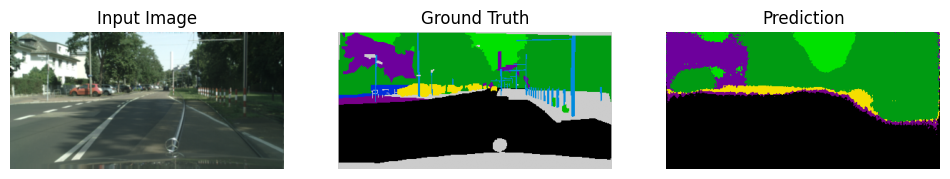

In [ ]:

def run_inference_example(model, dataloader, device):
    """Run inference on a single batch for demonstration"""
    model.eval()
    with torch.no_grad():
        images, labels = next(iter(dataloader))
        images, labels = images.to(device), labels.to(device)

        start = time.time()
        outputs = model(images)
        inference_time = time.time() - start

        preds = torch.argmax(outputs, dim=1)
        print(f"Inference time for batch of {images.size(0)}: {inference_time:.4f}s")
        print(f"Per image: {inference_time/images.size(0):.4f}s")
        return images[0], labels[0], preds[0]

# Load best model for inference demo
try:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = lightweight_segmentation(19).to(device)
    model.load_state_dict(torch.load('/content/drive/MyDrive/best_lightweight_segmentation.pth'))
    model = model.float()  # Ensure model is in float for inference

    print("\nRunning inference demo:")
    # Assume val_loader is defined in the main training (Cell 8) and available here.
    # If not, you might need to recreate the validation DataLoader similarly.
    _, val_dataset_temp = None, None  # Placeholder if needed; otherwise, reuse the same created dataloader.
    # For demo, you may reinstantiate the transform and dataset
    val_transform = CityscapesTransform(split='val', img_size=(384, 192))
    val_dataset_temp = CityscapesDataset(subset_path, split='val', transform=val_transform, cache_data=True)
    val_loader = DataLoader(val_dataset_temp, batch_size=8, shuffle=False, num_workers=2)

    image, label, pred = run_inference_example(model, val_loader, device)

    # Convert tensors for visualization
    image_np = image.cpu().numpy().transpose(1, 2, 0)
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image_np = std * image_np + mean
    image_np = np.clip(image_np, 0, 1)

    plt.figure(figsize=(12, 4))
    plt.subplot(131)
    plt.imshow(image_np)
    plt.title("Input Image")
    plt.axis('off')

    plt.subplot(132)
    plt.imshow(label.cpu().numpy(), cmap='nipy_spectral', vmin=0, vmax=18)
    plt.title("Ground Truth")
    plt.axis('off')

    plt.subplot(133)
    plt.imshow(pred.cpu().numpy(), cmap='nipy_spectral', vmin=0, vmax=18)
    plt.title("Prediction")
    plt.axis('off')

    plt.savefig('/content/drive/MyDrive/segmentation_result.png')
    plt.show()

except Exception as e:
    print(f"Error in inference demo: {e}")


# inference

imports and setup

In [ ]:

import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2  # OpenCV for image processing

# T4 GPU Memory Optimization: Enable benchmark for faster convolutions if input sizes are fixed
torch.backends.cudnn.benchmark = True


basic block implementation

In [ ]:

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()
        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        # Shortcut connection
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != self.expansion * out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, self.expansion * out_channels,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * out_channels)
            )

    def forward(self, x):
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        # Add shortcut connection
        out += self.shortcut(x)
        out = self.relu(out)
        return out


resnet architecture

In [ ]:

class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=19):  # 19 classes for Cityscapes
        super(ResNet, self).__init__()
        self.in_channels = 64

        # Initial convolution
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # Create ResNet layers
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)

        # Final classification layer (for semantic segmentation)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Conv2d(512 * block.expansion, num_classes, kernel_size=1)

    def _make_layer(self, block, out_channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.maxpool(self.relu(self.bn1(self.conv1(x))))
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.fc(x)
        return x


cityscape dataset

In [ ]:

class CityscapesDataset(Dataset):
    def __init__(self, root_dir, split='train', transform=None):
        self.root_dir = root_dir
        self.split = split
        self.transform = transform

        # Paths for images and masks
        self.image_dir = os.path.join(root_dir, 'leftImg8bit', split)
        self.mask_dir = os.path.join(root_dir, 'gtFine', split)

        # Collect image and mask paths
        self.images = []
        self.masks = []

        for city in os.listdir(self.image_dir):
            city_img_path = os.path.join(self.image_dir, city)
            city_mask_path = os.path.join(self.mask_dir, city)
            for img_name in os.listdir(city_img_path):
                img_path = os.path.join(city_img_path, img_name)
                mask_name = img_name.replace('leftImg8bit.png', 'gtFine_labelIds.png')
                mask_path = os.path.join(city_mask_path, mask_name)
                self.images.append(img_path)
                self.masks.append(mask_path)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        # Read image and mask
        image = cv2.imread(self.images[idx])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks[idx], cv2.IMREAD_UNCHANGED)
        # Apply transformations (Albumentations expects dictionaries)
        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']
        return image, mask


Data Tranformation

In [ ]:

def get_transforms(phase='train'):
    if phase == 'train':
        return A.Compose([
            A.Resize(height=512, width=1024),  # Cityscapes typical resolution
            A.HorizontalFlip(p=0.5),
            A.RandomBrightnessContrast(p=0.2),
            A.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225]),
            ToTensorV2()
        ])
    else:
        return A.Compose([
            A.Resize(height=512, width=1024),
            A.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225]),
            ToTensorV2()
        ])


Training function

In [ ]:

def train_model(model, train_loader, val_loader, criterion, optimizer,
                num_epochs=10, device=torch.device('cuda')):
    best_loss = float('inf')
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        for images, masks in train_loader:
            images = images.to(device)
            masks = masks.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        # Validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for images, masks in val_loader:
                images = images.to(device)
                masks = masks.to(device)
                outputs = model(images)
                loss = criterion(outputs, masks)
                val_loss += loss.item()
        # Print epoch statistics
        print(f'Epoch {epoch+1}/{num_epochs}')
        print(f'Train Loss: {train_loss/len(train_loader):.4f}')
        print(f'Val Loss: {val_loss/len(val_loader):.4f}')
        # Save best model
        if val_loss < best_loss:
            best_loss = val_loss
            torch.save(model.state_dict(), 'best_resnet_cityscapes.pth')


main

In [ ]:

def main():
    # Device configuration
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Model Initialization: using ResNet18 architecture (2,2,2,2 blocks)
    model = ResNet(BasicBlock, [2, 2, 2, 2])
    model = model.to(device)

    # Create datasets and dataloaders
    train_transform = get_transforms('train')
    val_transform = get_transforms('val')

    train_dataset = CityscapesDataset('/content/drive/MyDrive/cityscape', split='train', transform=train_transform)
    val_dataset = CityscapesDataset('/content/drive/MyDrive/cityscape', split='val', transform=val_transform)

    train_loader = DataLoader(train_dataset,
                              batch_size=8,  # Adjust based on GPU memory
                              shuffle=True,
                              num_workers=2,
                              pin_memory=True)
    val_loader = DataLoader(val_dataset,
                            batch_size=8,
                            shuffle=False,
                            num_workers=2,
                            pin_memory=True)

    # Loss and Optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Train the model
    train_model(model, train_loader, val_loader, criterion, optimizer,
                num_epochs=10, device=device)

if __name__ == '__main__':
    main()


RuntimeError: input and target batch or spatial sizes don't match: target [8, 512, 1024], input [8, 19, 16, 32]